In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Set up matplotlib style 
plt.style.use('ggplot')

# Libraries for wordcloud making and image importing
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# And libraries for data transformation
import datetime
from string import punctuation

# <a id="0">1.Data Preprocessing</a>

In [2]:
# Import data and transform tsv file
data = pd.read_csv('./Data/amazon_alexa.tsv', delimiter='\t')

In [3]:
num = '0123456789'

In [4]:
# Transform string data and remove punctuation, number
data['verified_reviews'] = data.verified_reviews.apply(lambda x: x.lower())
data['verified_reviews'] = data.verified_reviews.apply(lambda x: ''.join([c for c in x if c not in punctuation]))
data['verified_reviews'] = data.verified_reviews.apply(lambda x: ''.join([c for c in x if c not in num]))

In [5]:
# Add a new feature: the length of the review 
data['review_length'] = data.verified_reviews.apply(lambda x: len(x))

In [6]:
# Transform date to datetime data type
data['date'] = data.date.apply(lambda x:  datetime.datetime.strptime(x, '%d-%b-%y'))

In [7]:
print("The earliest date of review is %s " % min(data['date']))
print("The latest date of review is %s " %max(data['date']))

The earliest date of review is 2018-05-16 00:00:00 
The latest date of review is 2018-07-31 00:00:00 


## <a id="0">Obtain a new feature : buy_period = Review Date - Release Date</a>

In [8]:
echo_list = ['Charcoal Fabric ','Walnut Finish ','Heather Gray Fabric ','Sandstone Fabric ','Oak Finish ','Black','White']
spot_list = ['Black  Spot','White  Spot']
show_list = ['Black  Show','White  Show']
plus_list = ['Black  Plus''White  Plus']
dot_list = ['Black  Dot','White  Dot']

In [9]:
echo_date = datetime.datetime(2017, 10,31)
spot_date = datetime.datetime(2017, 9,27)
show_date = datetime.datetime(2017, 6,28)
plus_date = datetime.datetime(2017, 9,27)
dot_date = datetime.datetime(2016, 10,20)

In [10]:
def Gen_Buy_Period(variation,review_date):
    """
    Generating the buy period feature 
    Input: variation,the  date of review
    Output: review date - release date
    """
    release_date = datetime.datetime(2017, 10,31)
    if variation in echo_list:
        release_date = echo_date
    if variation in spot_list:
        release_date = spot_date
    if variation in show_list:
        release_date = show_date
    if variation in plus_list:
        release_date = plus_date
    if variation in dot_list:
        release_date = dot_date
    buy_period = review_date - release_date
    return buy_period.days

In [11]:
data['buy_period'] = list(map(lambda x,y: Gen_Buy_Period(x,y),data['variation'],data['date']))

## <a id="0">Scale the continuous variable buy_period and review_length</a>

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_columns = scaler.fit_transform(data[['buy_period','review_length']])
data = pd.concat([data, pd.DataFrame(scaled_columns,columns=['scaled_buy_period','scaled_review_length'])],axis=1)


C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
# This block is left for random forest

#from sklearn.preprocessing import LabelEncoder
#class_le = LabelEncoder()
#class_le.fit_transform(data['variation'].values)
#np.unique(class_le.fit_transform(data['variation'].values))

## <a id="0">Create 15 Dummy Variables for "Variation"</a>

In [14]:
dummy_columns = pd.get_dummies(data['variation'],prefix='variation',drop_first=True)
data = data.join(dummy_columns)

In [15]:
data.head()

,rating,date,variation,verified_reviews,feedback,review_length,buy_period,scaled_buy_period,scaled_review_length,variation_Black Dot,...,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,5,2018-07-31,Charcoal Fabric,love my echo,1,12,273,0.168142,0.004118,0,...,0,0,0,0,0,0,0,0,0,0
1,5,2018-07-31,Charcoal Fabric,loved it,1,8,273,0.168142,0.002621,0,...,0,0,0,0,0,0,0,0,0,0
2,4,2018-07-31,Walnut Finish,sometimes while playing a game you can answer ...,1,192,273,0.168142,0.071509,0,...,0,0,0,0,1,0,0,0,0,0
3,5,2018-07-31,Charcoal Fabric,i have had a lot of fun with this thing my yr...,1,167,273,0.168142,0.062149,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2018-07-31,Charcoal Fabric,music,1,5,273,0.168142,0.001498,0,...,0,0,0,0,0,0,0,0,0,0


# <a id="0">2.Data Visualization</a>

## <a id="0">2.1 Histogram</a>

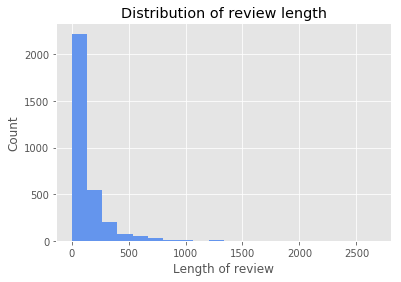

In [16]:
# Distribution of review Length
data['review_length'].hist(bins=20,color='cornflowerblue')
plt.ylabel('Count')
plt.xlabel('Length of review')
plt.title('Distribution of review length')
plt.tick_params(labelsize=10)
plt.savefig('./img/hist_review_length.png')

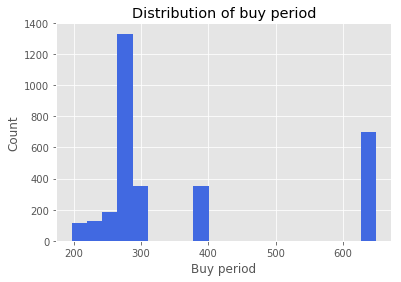

In [17]:
# Distribution of buy period
data['buy_period'].hist(bins=20,color='royalblue')
plt.ylabel('Count')
plt.xlabel('Buy period')
plt.title('Distribution of buy period')
plt.tick_params(labelsize=10)
plt.savefig('./img/hist_buy_period.png')

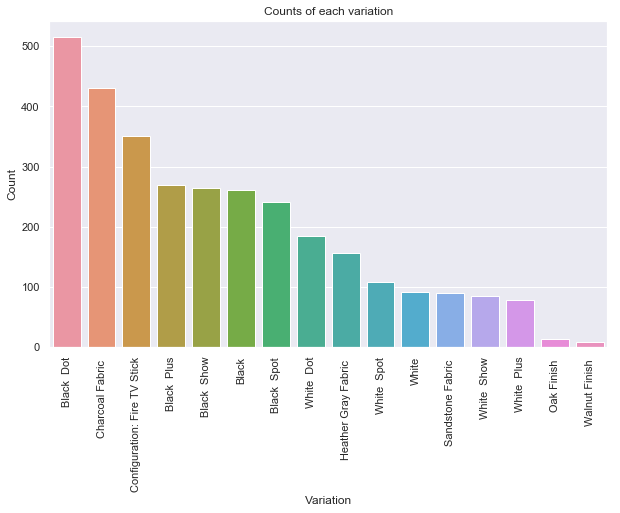

In [18]:
# Distribution of variation
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data.variation,
              order = data['variation'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel("Variation")
plt.ylabel("Count")
plt.title('Counts of each variation')
plt.savefig('./img/hist_variation.png')

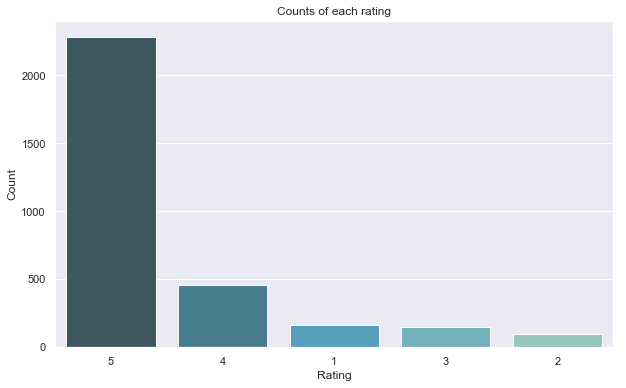

In [19]:
# Distribution of rating

sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data.rating,palette=sns.color_palette("GnBu_d",5),
              order = data['rating'].value_counts().index)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title('Counts of each rating')
plt.savefig('./img/hist_rating.png')

## <a id="0">2.2 Boxplot</a>

### <a id="0">Variation vs. Rating</a>

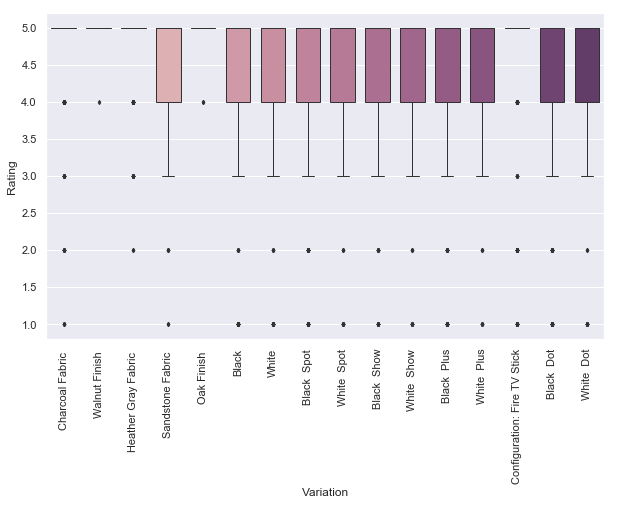

In [20]:
# Boxplot: Variation vs. Rating
sns.boxplot(data.variation, data.rating,width=0.7,fliersize=3,linewidth=1,palette=sns.cubehelix_palette(20),saturation=0.9)
plt.xlabel("Variation")
plt.ylabel("Rating")
plt.xticks(rotation = 90)
plt.savefig('./img/boxplot_rating_variation.png')

### <a id="0">Review Length vs. Rating</a>

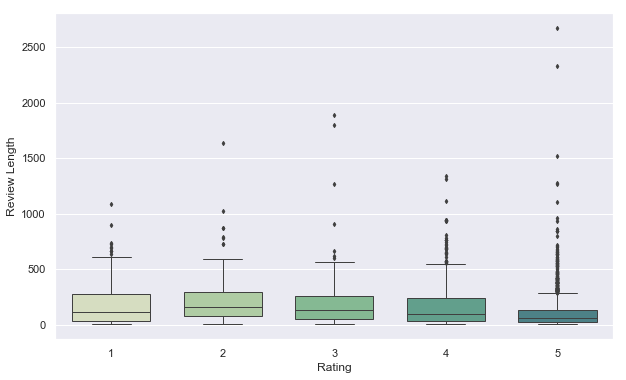

In [21]:
# Boxplot: Review Length vs. Rating
sns.boxplot(data.rating, data.review_length,width=0.7,fliersize=3,linewidth=1,palette=sns.cubehelix_palette(8, start=.5, rot=-.75),saturation=0.9)
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.savefig('./img/boxplot_review_rating.png')

### <a id="0">Log Review Length vs. Rating</a>

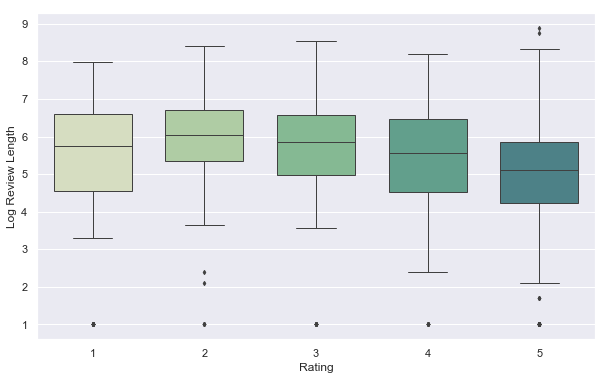

In [22]:
data['log_review_length'] = data.review_length.apply(lambda x: (np.log(x)+1))
# Boxplot: Log Review Length vs. Rating
sns.boxplot(data.rating, data.log_review_length,width=0.7,fliersize=3,linewidth=1,palette=sns.cubehelix_palette(8, start=.5, rot=-.75),saturation=0.9)
plt.xlabel("Rating")
plt.ylabel("Log Review Length")
plt.savefig('./img/boxplot_review_rating_log.png')

### <a id="0">Buy Period vs. Rating</a>

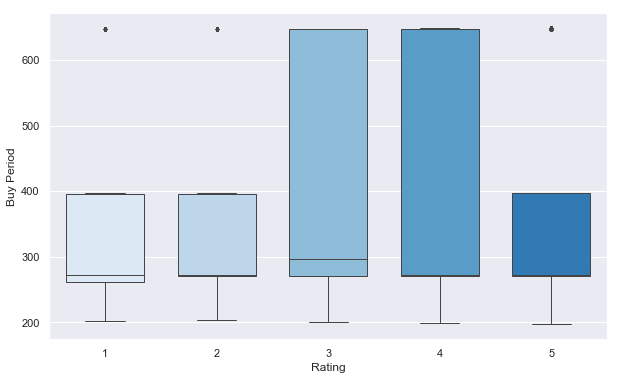

In [23]:
# Boxplot: Buy Period vs. Rating
sns.boxplot(data.rating, data.buy_period,width=0.7,fliersize=3,linewidth=1,palette=sns.color_palette("Blues"),saturation=0.9)
plt.xlabel("Rating")
plt.ylabel("Buy Period")
plt.savefig('./img/boxplot_period_rating.png')

### <a id="0">Log Buy Period vs. Rating</a>

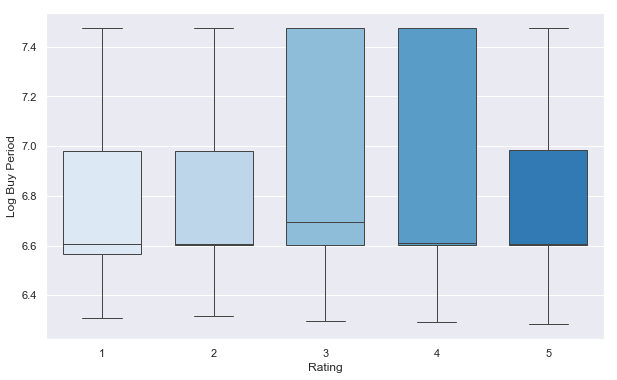

In [24]:
data['log_buy_period'] = data.buy_period.apply(lambda x: (np.log(x)+1))
# Boxplot: Log Review Length vs. Rating
sns.boxplot(data.rating, data.log_buy_period,width=0.7,fliersize=3,linewidth=1,palette=sns.color_palette("Blues"),saturation=0.9)
plt.xlabel("Rating")
plt.ylabel("Log Buy Period")
plt.savefig('./img/boxplot_period_rating_log.png')

## <a id="0">2.3 WordCloud</a>

### <a id="0">Review</a>

In [25]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VitoDH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VitoDH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

# Wanna make word cloud to be meaningful
stop_words.add('alexa')
stop_words.add('echo')
stop_words.add('one')
stop_words.add('dot')
stop_words.add('thing')
stop_words.add('product')
stop_words.add('device')
stop_words.add('devices')
stop_words.add('speaker')
stop_words.add('amazon')
stop_words.add('month')
stop_words.add('even')
stop_words.add('work')
stop_words.add('months')
stop_words.add('time')
stop_words.add('screen')
stop_words.add('buy')
stop_words.add('bought')
stop_words.add('back')
stop_words.add('works')
stop_words.add('working')
stop_words.add('worked')
stop_words.add('light')
stop_words.add('really')
stop_words.add('use')
stop_words.add('item')
stop_words.add('phone')
stop_words.add('app')
stop_words.add('wifi')
stop_words.add('hub')

data['cleaned_reviews'] = data.verified_reviews.apply(lambda x: word_tokenize(x))
data['cleaned_reviews'] = data.cleaned_reviews.apply(lambda x: [w for w in x if w not in stop_words])
data['cleaned_reviews'] = data.cleaned_reviews.apply(lambda x: ' '.join(x))


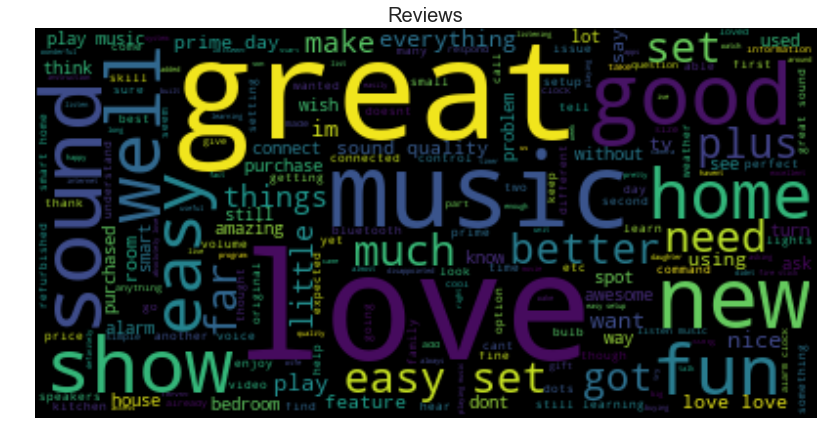

In [27]:
np.random.seed(321)
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(data['cleaned_reviews'].tolist())

########  mask = A
wordcloud = WordCloud(background_color="black",random_state=53).generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.savefig('./img/word_cloud_all.png')
plt.show()

In [28]:
data5 = data[data.rating == 5]
data_not_5 = data[data.rating != 5]
data1 = data[data.rating == 1]
data2 = data[data.rating == 2]
data1_2=pd.concat([data1,data2])

### <a id="0">Review of Rating 5</a>

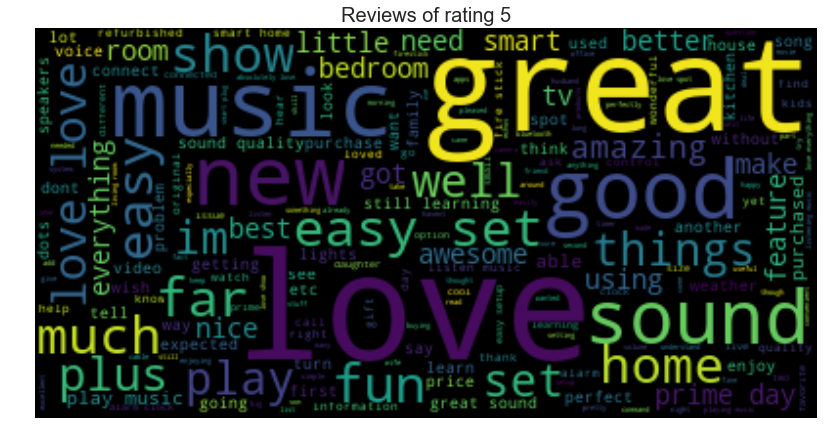

In [29]:
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(data5['cleaned_reviews'].tolist())

wordcloud = WordCloud(background_color="black",random_state=53).generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews of rating 5',size=20)
plt.savefig('./img/word_cloud_5.png')
plt.show()

### <a id="0">Review of Rating 1</a>

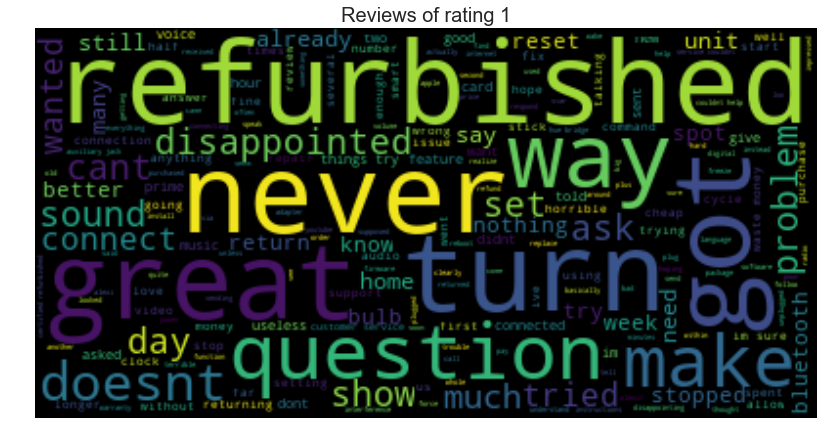

In [30]:
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(data1['cleaned_reviews'].tolist())

wordcloud = WordCloud(background_color="black",random_state=53).generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews of rating 1',size=20)
plt.savefig('./img/word_cloud_1.png')
plt.show()

## <a id="0">2.4 Trend</a>

There is a sharp increase of reviews from July 28 to July 30 in 2018. Need to check?

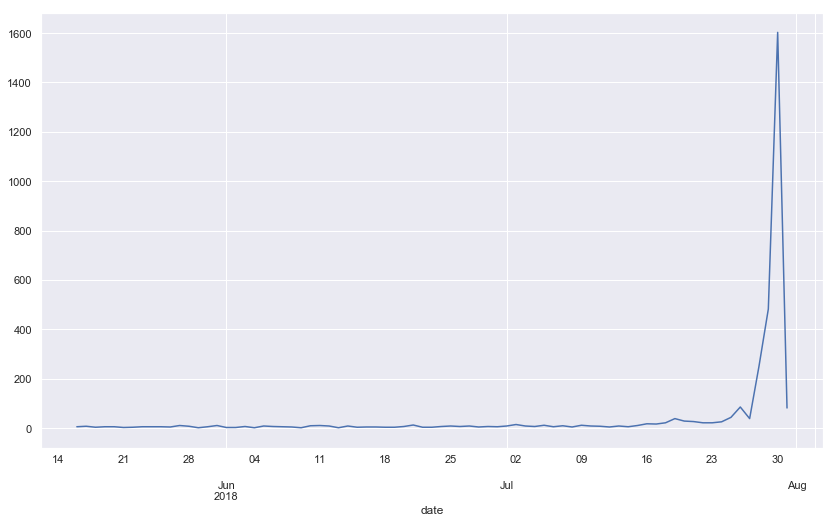

In [31]:
data_date = data.groupby('date').count()
data_date.rating.plot()
plt.savefig('./img/review_trend.png')

# <a id="0">3.Data Splitting and Training</a>

## <a id="0">3.1 Label</a>

In [32]:
data['label'] = 0
data.loc[data['rating'] ==5, 'label'] = 1
y = data['label']

In [33]:
# remove useless columns
data = data.drop(columns = ['log_review_length','log_buy_period'])

## <a id="0">3.2 Feature Selection and Training</a>

In this part, we only use the word vector for training.

In [34]:
def feature_selection_chi(k,raw_train, y_train,raw_test,y_test,feature_list):
    """
    Select the features(words) from word vec
    
    Input: k: number of features to select; raw_train:word vector of training set; raw_test: word vector of test;
     y_train:label of train; y_test: label of test
     feature_list: vocabulary vector
    
    Output: the k feature selected for training set and test set and the feature names
    """
    ch2 = SelectKBest(chi2, k)
    raw_train_k = ch2.fit_transform(raw_train, y_train)
    raw_train = pd.DataFrame(raw_train.A,columns=feature_list)

    sel_feat_index = raw_train.columns[ch2.get_support(indices=True)].tolist()
    raw_test_k = ch2.transform(X=raw_test)
    
    return raw_train_k,raw_test_k,sel_feat_index


In [35]:
def combine_features(X_train,X_test,raw_train_k,raw_test_k,sel_feat_list):
    """
    Combine the features selected from word Vector with the features in the original dataset
    
    Input: X_train: original training set; X_test: original test set
    raw_train_k: selected word vector of training set; 
    raw_test_k: selected word vector of test set
    sel_feat_list: the names of the selected features
    
    Output: the ultimate training set and test set
    """
    raw_train_k = pd.DataFrame(raw_train_k.toarray(),columns=sel_feat_list)
    raw_train_k = raw_train_k.set_index(X_train.index)
    X_train_new = pd.concat([raw_train_k,X_train],axis=1)   

    raw_test_k = pd.DataFrame(raw_test_k.toarray(),columns=sel_feat_list)
    raw_test_k = raw_test_k.set_index(X_test.index)
    X_test_new = pd.concat([raw_test_k,X_test],axis=1)
    
    return X_train_new,X_test_new

In [36]:
def train_data(X_train,y_train,X_test,y_test):
    """
    Training and calculate the performance
    
    Input: X_train: training set with all features; X_test: test set with all features
    y_train:label of train; y_test: label of test
    
    Output: accuracy,f1 score, auc and the model
    """
    if isinstance(X_train,pd.DataFrame):
        X_train = X_train.values
        X_test = X_test.values
    
    log_clf = LogisticRegression(random_state=100,class_weight="balanced").fit(X_train,y_train)
    pred = log_clf.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = metrics.accuracy_score(y_test, pred)
    
    # Calculate the auc score
    score = metrics.roc_auc_score(y_test, pred)

    # Calculate the f1 score
    f1 = metrics.f1_score(y_test, pred)

    return accuracy,f1, score,log_clf



### <a id="0">Selection Method 1: Count Vectorizer</a>

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train, X_test, y_train, y_test = train_test_split(data.loc[:,'scaled_buy_period':'cleaned_reviews'], y, test_size=0.2
                                    ,random_state=53)

# Initialize a CountVectorizer object: count_vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
count_vectorizer = CountVectorizer(stop_words="english")


# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train.loc[:,'cleaned_reviews'])
count_features = count_vectorizer.get_feature_names()

y_train = np.asarray(y_train.values)

count_test = count_vectorizer.transform(X_test.loc[:,'cleaned_reviews'])
y_test = np.asarray(y_test.values)

                                             
                                
                                    

In [38]:
X_train = X_train.drop(columns = 'cleaned_reviews')
X_test = X_test.drop(columns = 'cleaned_reviews')

In [39]:
k_list = [1,3,10,30,100,300,1000,3000]
accuracy_list = []
f1_list = []
auc_list = []

for k in k_list:
    count_train_k,count_test_k,sel_feat_names = feature_selection_chi(k,count_train, y_train,count_test,y_test,count_features)
    #X_train_new, X_test_new = combine_features(X_train,X_test,count_train_k,count_test_k,sel_feat_names)
    
    #accuracy, f1, score,_ = train_data(X_train_new,y_train,X_test_new,y_test)
    accuracy, f1, score,_ = train_data(count_train_k,y_train,count_test_k,y_test)
    
    accuracy_list.append(accuracy)
    f1_list.append(f1)
    auc_list.append(score)

C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

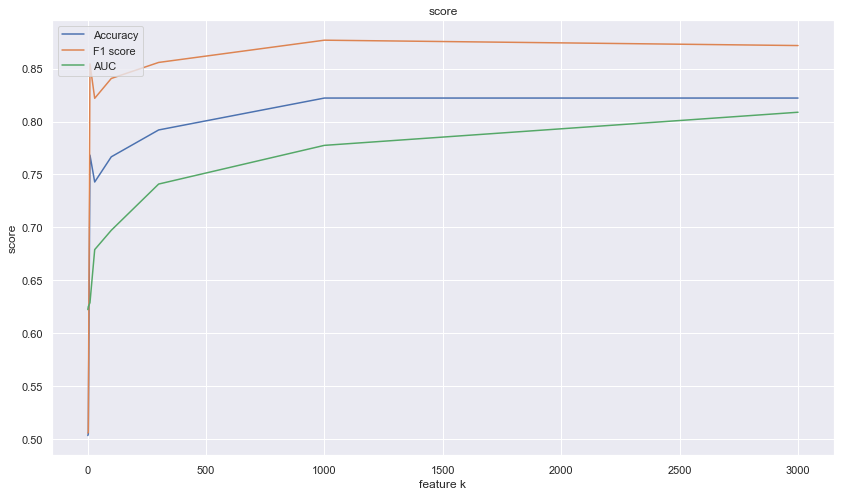

In [40]:
plt.plot(k_list, accuracy_list,label='Accuracy')
plt.xlabel('feature k')
plt.ylabel('score')

plt.plot(k_list, f1_list,label='F1 score')
plt.xlabel('feature k')
plt.ylabel('score')

plt.plot(k_list, auc_list,label='AUC')
plt.legend(loc='upper left')
plt.title("score")

plt.savefig('./img/count_score_select_k.png')

### <a id="0">Selection Method 2: TFIDF</a>

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train, X_test, y_train, y_test = train_test_split(data.loc[:,'scaled_buy_period':'cleaned_reviews'], y, test_size=0.2,random_state=53)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.loc[:,'cleaned_reviews'])
tfidf_features = tfidf_vectorizer.get_feature_names()

y_train = np.asarray(y_train.values)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.loc[:,'cleaned_reviews'])
y_test = np.asarray(y_test.values)

In [42]:
X_train = X_train.drop(columns = 'cleaned_reviews')
X_test = X_test.drop(columns = 'cleaned_reviews')

In [43]:
k_list = [1,3,10,30,100,300,1000,3000]
accuracy_list = []
f1_list = []
auc_list = []

for k in k_list:
    tfidf_train_k,tfidf_test_k,sel_feat_names = feature_selection_chi(k,tfidf_train, y_train,tfidf_test,y_test,tfidf_features)
    #X_train_new, X_test_new = combine_features(X_train,X_test,tfidf_train_k,tfidf_test_k,sel_feat_names)
    
    #accuracy, f1, score,_ = train_data(X_train_new,y_train,X_test_new,y_test)
    accuracy, f1, score,_ = train_data(tfidf_train_k,y_train,tfidf_test_k,y_test)
    accuracy_list.append(accuracy)
    f1_list.append(f1)
    auc_list.append(score)

C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

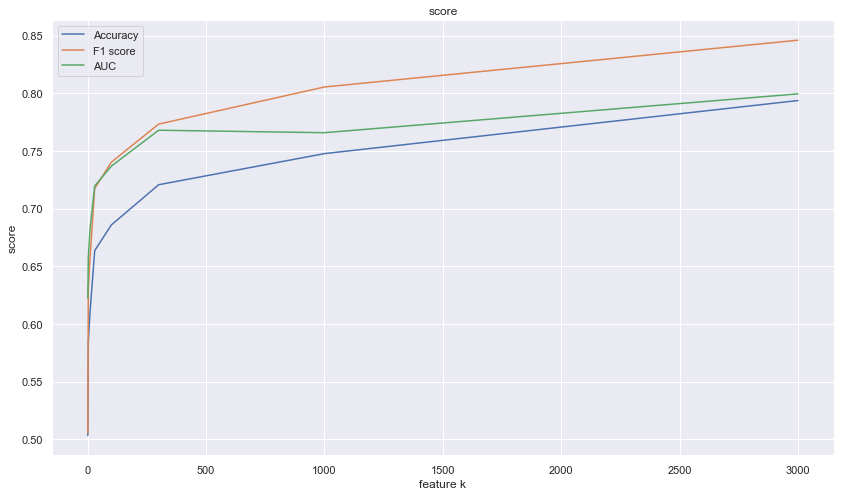

In [44]:
plt.plot(k_list, accuracy_list,label='Accuracy')
plt.xlabel('feature k')
plt.ylabel('score')

plt.plot(k_list, f1_list,label='F1 score')
plt.xlabel('feature k')
plt.ylabel('score')

plt.plot(k_list, auc_list,label='AUC')
plt.legend(loc='upper left')
plt.title("score")
plt.savefig('./img/tfidf_score_select_k.png')

# <a id="0">4.Model Selection</a>

## <a id="0">4.1 Select K=300</a>

K refers to the number of features for the words.

In [45]:
import statsmodels.api as sm
from pdpbox import pdp, get_dataset, info_plots
from sklearn.linear_model import LogisticRegressionCV



## <a id="0">4.2 Cross Validation</a>

The metrics for cross validation is f1 score.

In [46]:
from collections import Counter
from sklearn.model_selection import KFold,StratifiedKFold
count_train_300,count_test_300,sel_feat_names = feature_selection_chi(300,count_train, y_train,count_test,y_test,count_features)
tfidf_train_300,tfidf_test_300,sel_feat_names = feature_selection_chi(300,tfidf_train, y_train,tfidf_test,y_test,tfidf_features)

In [47]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5
score = 'f1'

y = y_train.copy()
y.sort()
Counter(y)

Counter({0: 688, 1: 1832})

In [48]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)



    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 2500])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

### <a id="0">K Fold</a>

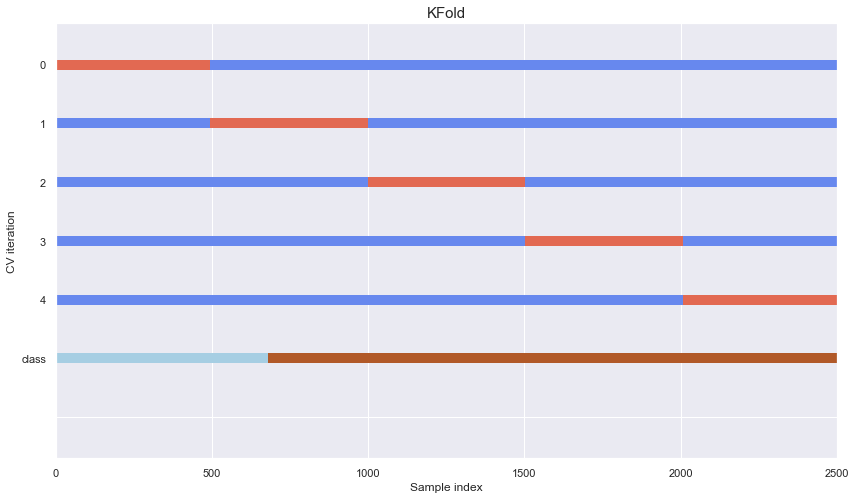

In [49]:
fig, ax = plt.subplots()
kfold_cv = KFold(n_splits)
plot_cv_indices(kfold_cv, count_train_300.A, y, ax, n_splits)
plt.savefig('./img/Kfold.png')

### <a id="0">Stratified K Fold</a>

Noting that in the traditional k fold, the 1st fold will pick most of the data points with label 0, leaving little "0" for the remained folds. Stratified K fold perfectly solve this problem.

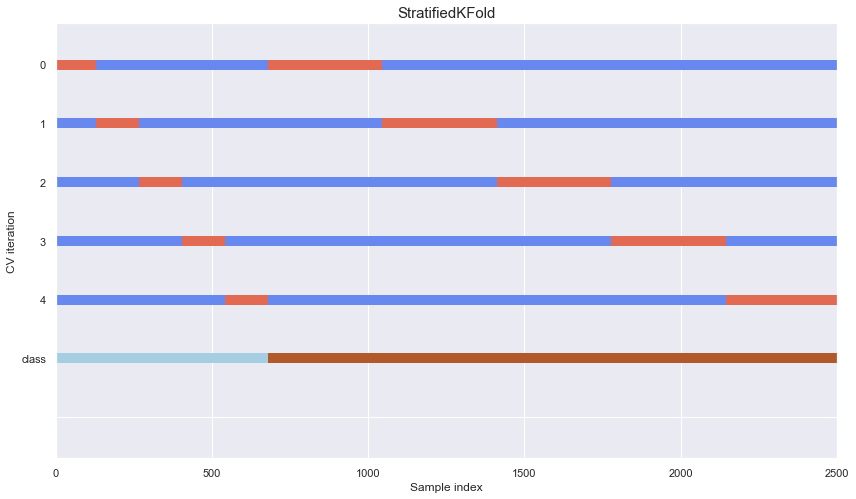

In [50]:
fig, ax = plt.subplots()
stratified_cv = StratifiedKFold(n_splits)
plot_cv_indices(stratified_cv, count_train_300.A, y, ax, n_splits)
plt.savefig('./img/StratifiedKfold.png')

### <a id="0">Count Vectorizer</a>

#### <a id="0">CV on count_train_300</a>

In [51]:
count_train_300,count_test_300,sel_feat_names = feature_selection_chi(300,count_train, y_train,count_test,y_test,count_features)

clf_count_cv = LogisticRegressionCV(cv=n_splits,class_weight="balanced",scoring=score,random_state=53).fit(count_train_300.A, y_train)
print("The best penalty parameter C_ for the cv is: %f" % clf_count_cv.C_[0])

count_train_300_score = max(np.array(pd.DataFrame.mean(pd.DataFrame(clf_count_cv.scores_[1]),axis=0)))
print("The corresponding average f1 score over all the fold is: %f" % count_train_300_score)


The best penalty parameter C_ for the cv is: 2.782559
The corresponding average f1 score over all the fold is: 0.862112


#### <a id="0">CV on training set(count) with all features</a>

Including the count features and the date,variation and review length

In [52]:
# Combine all the features
X_train_new, X_test_new = combine_features(X_train,X_test,count_train_300,count_test_300,sel_feat_names)
count_feat_names = X_train_new.columns

clf_count_all_cv = LogisticRegressionCV(cv=n_splits,class_weight="balanced",scoring=score,random_state=53).fit(X_train_new.values, y_train)
print("The best penalty parameter C_ for the cv is: %f" % clf_count_all_cv.C_[0])

count_train_all_score = max(np.array(pd.DataFrame.mean(pd.DataFrame(clf_count_all_cv.scores_[1]),axis=0)))
print("The corresponding average f1 score over all the fold is: %f" % count_train_all_score)


The best penalty parameter C_ for the cv is: 166.810054
The corresponding average f1 score over all the fold is: 0.841270


### <a id="0">TFIDF</a>

#### <a id="0">CV on tfidf_train_300</a>

In [53]:
# Tiidf Vectorizer
tfidf_train_300,tfidf_test_300,sel_feat_names = feature_selection_chi(300,tfidf_train, y_train,tfidf_test,y_test,tfidf_features)
clf_tfidf_cv = LogisticRegressionCV(cv=n_splits,class_weight="balanced",scoring=score,random_state=53).fit(tfidf_train_300.A, y_train)
print("The best penalty parameter C_ for the cv is: %f" % clf_tfidf_cv.C_[0])

tfidf_train_300_score = max(np.array(pd.DataFrame.mean(pd.DataFrame(clf_tfidf_cv.scores_[1]),axis=0)))
print("The corresponding average f1 score over all the fold is: %f" % tfidf_train_300_score)


The best penalty parameter C_ for the cv is: 21.544347
The corresponding average f1 score over all the fold is: 0.885345


#### <a id="0">CV on training set(tfidf) with all features</a>

In [54]:
X_train_new, X_test_new = combine_features(X_train,X_test,tfidf_train_300,tfidf_test_300,sel_feat_names)    
tfidf_feat_names = X_train_new.columns
#accuracy, f1, score,tfidf_clf = train_data(X_train_new,y_train,X_test_new,y_test)

clf_tfidf_all_cv = LogisticRegressionCV(cv=n_splits,class_weight="balanced",scoring=score,random_state=53).fit(X_train_new.values, y_train)
print("The best penalty parameter C_ for the cv is: %f" % clf_tfidf_all_cv.C_[0])

tfidf_train_all_score = max(np.array(pd.DataFrame.mean(pd.DataFrame(clf_tfidf_all_cv.scores_[1]),axis=0)))
print("The corresponding average f1 score over all the fold is: %f" % tfidf_train_all_score)


The best penalty parameter C_ for the cv is: 10000.000000
The corresponding average f1 score over all the fold is: 0.885560


In [55]:
summary_array = np.array([[count_train_300_score,count_train_all_score],[tfidf_train_300_score,tfidf_train_all_score]])
summary_df = pd.DataFrame(summary_array,index=['count','tfidf'],columns=['300 features','all features'])
summary_df

,300 features,all features
count,0.862112,0.84127
tfidf,0.885345,0.88556


Based on the above table of f1 score on CV, we finally choose tfidf to vectorize the reviews and use all the features we have. 

# <a id="0">5.Performance</a>

## <a id="0">5.1 Test Set

In [56]:
# refit the model
tfidf_train_300,tfidf_test_300,sel_feat_names = feature_selection_chi(300,tfidf_train, y_train,tfidf_test,y_test,tfidf_features)
X_train_new, X_test_new = combine_features(X_train,X_test,tfidf_train_300,tfidf_test_300,sel_feat_names)    
tfidf_feat_names = X_train_new.columns
clf_tfidf_all_cv = LogisticRegressionCV(cv=n_splits,class_weight="balanced",scoring=score,random_state=53).fit(X_train_new.values, y_train)

# f1_score on test set
test_score = clf_tfidf_all_cv.score(X_test_new.values,y_test)

print("The f1 score over the test set is: %f" % test_score)


The f1 score over the test set is: 0.865156


## <a id="0">5.2 Selected Features in Vocabulary

In [57]:
print("The 300 features selected based on tfidf_vectorizer are:")
print(sel_feat_names)

The 300 features selected based on tfidf_vectorizer are:
['absolutely', 'account', 'accounts', 'accurately', 'activate', 'activities', 'adapter', 'advantage', 'agree', 'alright', 'amazing', 'annoying', 'answer', 'answering', 'answers', 'apparently', 'apple', 'arent', 'ase', 'asked', 'askmy', 'auxiliary', 'awesome', 'awful', 'barry', 'basic', 'bass', 'battery', 'best', 'better', 'blue', 'bluetooth', 'booksthe', 'bridge', 'bulb', 'buld', 'buttons', 'cancel', 'capable', 'case', 'change', 'cheap', 'college', 'come', 'comes', 'commands', 'compared', 'compliments', 'components', 'concise', 'confuses', 'connection', 'contacted', 'cord', 'correctly', 'cutie', 'cycle', 'daughter', 'days', 'deaf', 'decrease', 'degrees', 'dependable', 'didnt', 'disappointed', 'disappointing', 'disappointment', 'doesnt', 'dont', 'dumb', 'dumber', 'easy', 'effort', 'eh', 'engine', 'enjoying', 'enter', 'error', 'espanol', 'event', 'example', 'excellent', 'excitement', 'fabulous', 'fairly', 'favorite', 'feels', 'fide

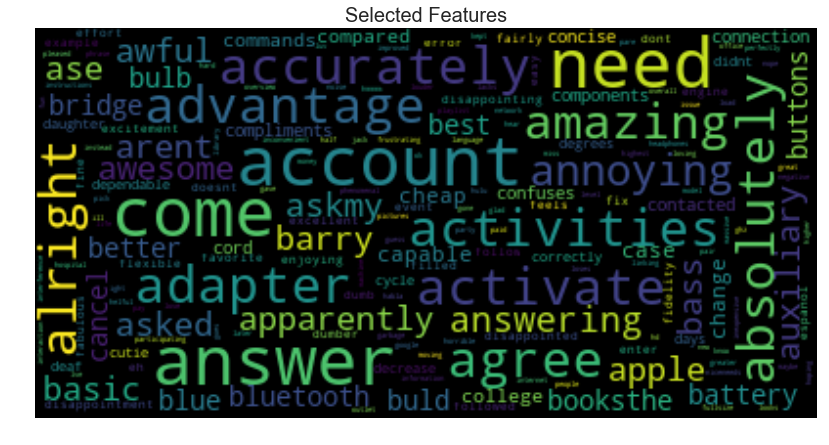

In [58]:
wordcloud = WordCloud(background_color="black",random_state=53,max_font_size=35).generate(' '.join(sel_feat_names))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Selected Features',size=20)
plt.savefig('./img/word_cloud_selected_feat.png')
plt.show()

### <a id="0">5.3 PDP Plot

### <a id="0">PDP for love</a>

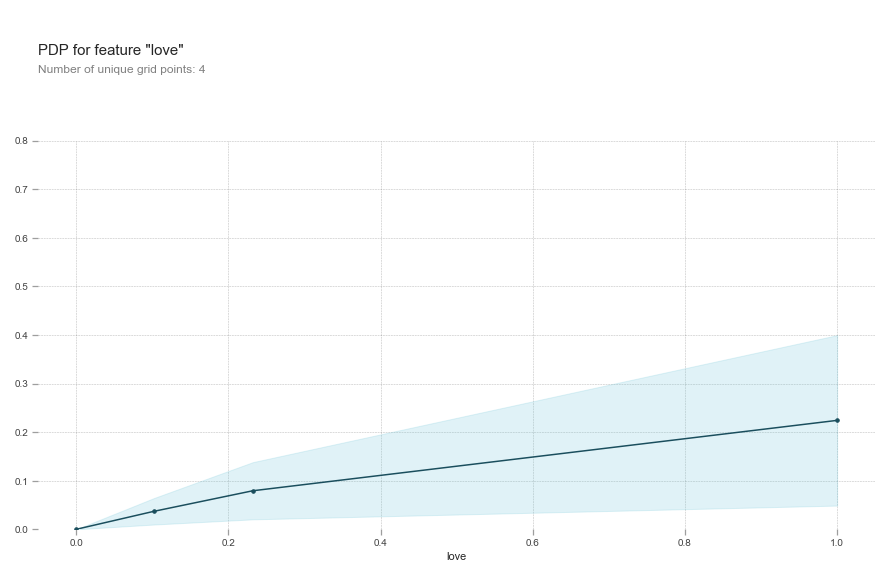

In [59]:
pdp_goals = pdp.pdp_isolate(model=clf_tfidf_all_cv, dataset=X_train_new, model_features=tfidf_feat_names, feature='love')

pdp.pdp_plot(pdp_goals, 'love')
plt.savefig('./img/pdp_love.png')
plt.show()

### <a id="0">PDP for disappointing</a>

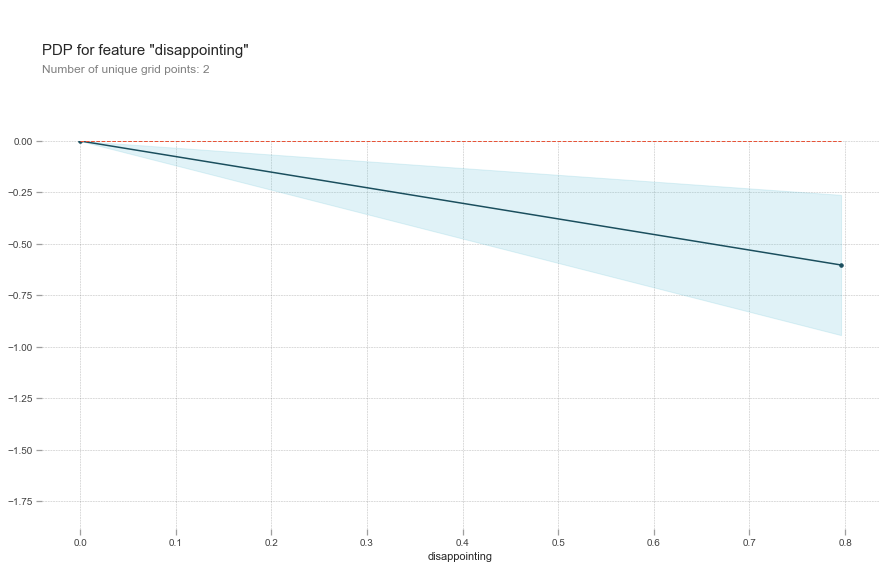

In [60]:
pdp_goals = pdp.pdp_isolate(model=clf_tfidf_all_cv, dataset=X_train_new, model_features=tfidf_feat_names, feature='disappointing')

pdp.pdp_plot(pdp_goals, 'disappointing')
plt.savefig('./img/pdp_disappointing.png')
plt.show()

### <a id="0">PDP for scale review length</a>

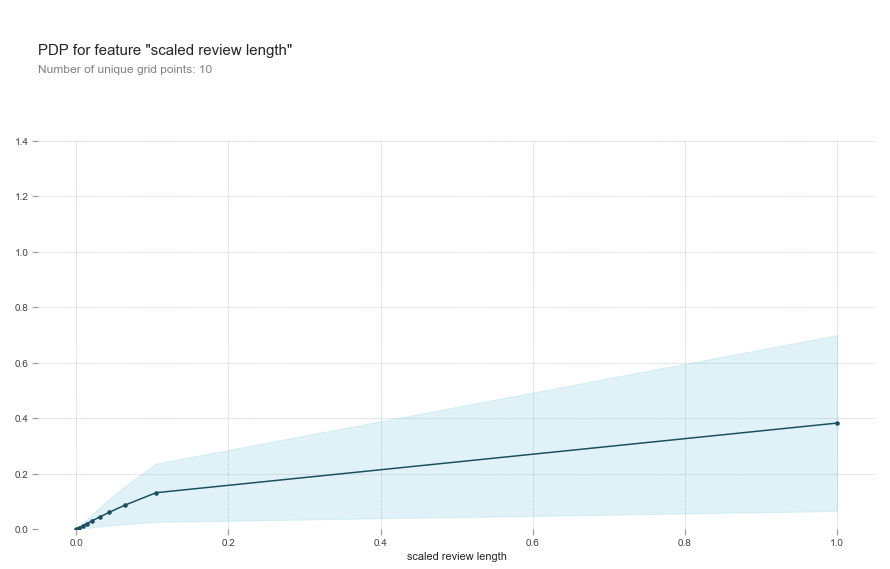

In [61]:
pdp_goals = pdp.pdp_isolate(model=clf_tfidf_all_cv, dataset=X_train_new, model_features=tfidf_feat_names, feature='scaled_review_length')

pdp.pdp_plot(pdp_goals, 'scaled review length')
plt.savefig('./img/pdp_scale_review_length.png')
plt.show()

### <a id="0">PDP for scaled buy period</a>

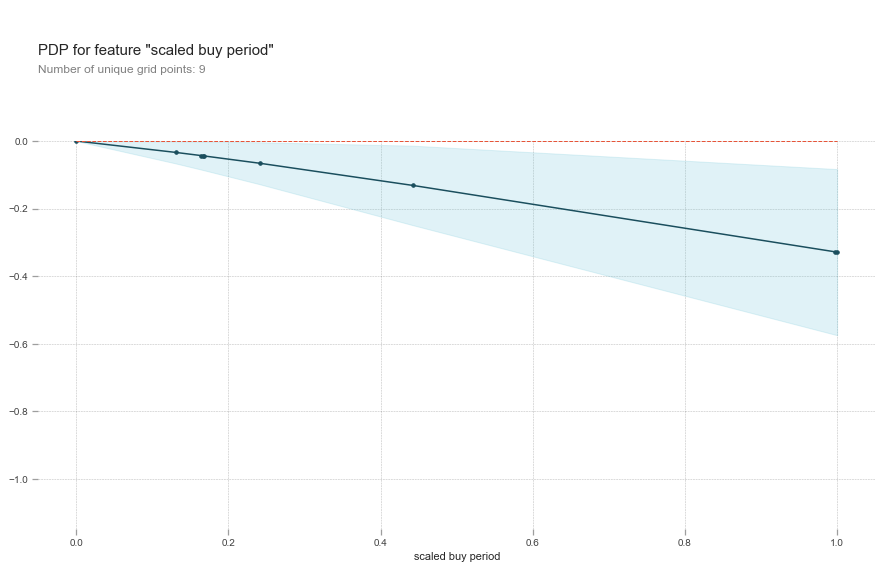

In [62]:
pdp_goals = pdp.pdp_isolate(model=clf_tfidf_all_cv, dataset=X_train_new, model_features=tfidf_feat_names, feature='scaled_buy_period')

pdp.pdp_plot(pdp_goals, 'scaled buy period')
plt.savefig('./img/pdp_scale_buy_period.png')
plt.show()

### <a id="0">PDP for variation white</a>

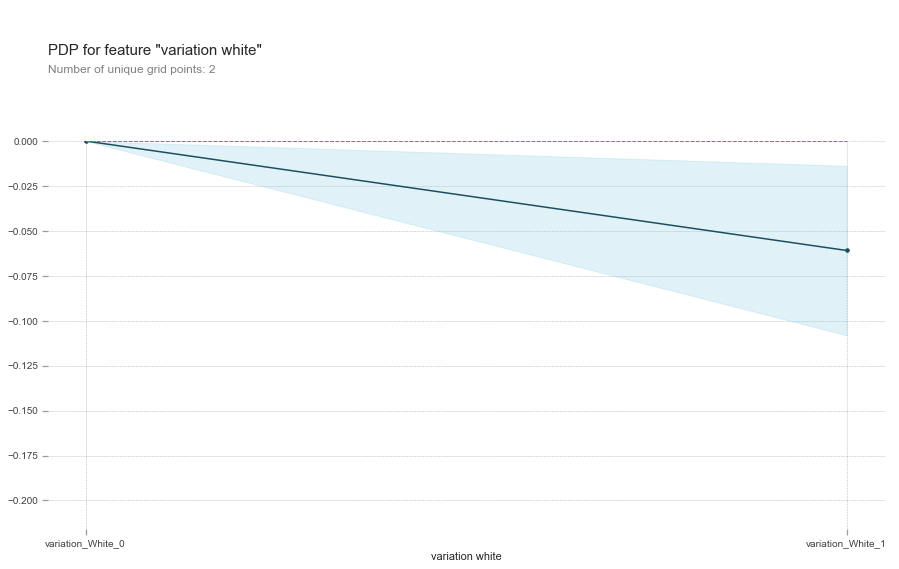

In [63]:
pdp_goals = pdp.pdp_isolate(model=clf_tfidf_all_cv, dataset=X_train_new, model_features=tfidf_feat_names, feature='variation_White')

pdp.pdp_plot(pdp_goals, 'variation white')
plt.savefig('./img/pdp_variation_white.png')
plt.show()
